# Stock Price Prediction Model

## Dependencies

### Library Installation (if needed)

In [1]:
#! pip install -Ur requirements.txt

### Importing Required Libraries

In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
import warnings
from methods.model_methods import *
from datetime import datetime
from tqdm import tqdm
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

/home/victorvj/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
Stock("AAPL").get_df_financials()

,Ticker,Name,Date,Earn Index,Sector,Industry,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,...,InterestExpenseNonOperating,InterestIncomeNonOperating,OperatingIncome,OperatingExpense,ResearchAndDevelopment,SellingGeneralAndAdministration,GrossProfit,CostOfRevenue,TotalRevenue,OperatingRevenue
0,AAPL,Apple Inc.,2025-06-30,0,Technology,Consumer Electronics,NaN,0.0,0.163997,3.103200e+10,...,NaN,NaN,2.820200e+10,1.551600e+10,8.866000e+09,6.650000e+09,4.371800e+10,5.031800e+10,9.403600e+10,9.403600e+10
0,AAPL,Apple Inc.,2025-03-31,1,Technology,Consumer Electronics,-0.075141,0.0,0.155000,3.225000e+10,...,NaN,NaN,2.958900e+10,1.527800e+10,8.550000e+09,6.728000e+09,4.486700e+10,5.049200e+10,9.535900e+10,9.535900e+10
0,AAPL,Apple Inc.,2024-12-31,2,Technology,Consumer Electronics,-0.107757,0.0,0.147000,4.591200e+10,...,NaN,NaN,4.283200e+10,1.544300e+10,8.268000e+09,7.175000e+09,5.827500e+10,6.602500e+10,1.243000e+11,1.243000e+11
0,AAPL,Apple Inc.,2024-09-30,3,Technology,Consumer Electronics,0.083594,0.0,0.241000,1.346610e+11,...,NaN,NaN,1.232160e+11,5.746700e+10,3.137000e+10,2.609700e+10,1.806830e+11,2.103520e+11,3.910350e+11,3.910350e+11
0,AAPL,Apple Inc.,2024-06-30,4,Technology,Consumer Electronics,0.082773,0.0,0.159000,2.820200e+10,...,NaN,NaN,2.535200e+10,1.432600e+10,8.006000e+09,6.320000e+09,3.967800e+10,4.609900e+10,8.577700e+10,8.577700e+10
0,AAPL,Apple Inc.,2023-09-30,5,Technology,Consumer Electronics,0.126007,0.0,0.147000,1.258200e+11,...,3.933000e+09,3.750000e+09,1.143010e+11,5.484700e+10,2.991500e+10,2.493200e+10,1.691480e+11,2.141370e+11,3.832850e+11,3.832850e+11
0,AAPL,Apple Inc.,2022-09-30,6,Technology,Consumer Electronics,-0.058281,0.0,0.162000,1.305410e+11,...,2.931000e+09,2.825000e+09,1.194370e+11,5.134500e+10,2.625100e+10,2.509400e+10,1.707820e+11,2.235460e+11,3.943280e+11,3.943280e+11
0,AAPL,Apple Inc.,2021-09-30,7,Technology,Consumer Electronics,0.261202,0.0,0.133000,1.231360e+11,...,2.645000e+09,2.843000e+09,1.089490e+11,4.388700e+10,2.191400e+10,2.197300e+10,1.528360e+11,2.129810e+11,3.658170e+11,3.658170e+11


### Variables

In [4]:
symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
if symbol_list:
    build_new_dataset = True
else:
    build_new_dataset = False
    symbol_list = 'filtered'
minimum_feature_threshold = 0.6
outlier = 3
iterations = input("Iterations eg. '10', '20', '30'")
if iterations:
    iterations = ast.literal_eval(iterations)
    train_new_model = True
    search_params = {
            "hidden_layer_amount": Integer(2, 10),
            "neuron_amount": Integer(20, 500),
            "warm_start": Categorical([False, True]),
            "activation": Categorical(['identity', 'logistic', 'tanh', 'relu']),
            "solver": Categorical(['sgd', 'adam', 'lbfgs']),
            "alpha": Real(0.000001, 1),
            "learning_rate_init": Real(0.00001, 0.1),
            "power_t": Real(0.0001, 100),
            "momentum": Real(0.0001, 100),
            "validation_fraction": Real(0.05, 0.20),
            "beta_1": Real(0.001, 10),
            "beta_2": Real(0.0001, 100),
            "epsilon": Real(0.0000000001, 0.000001),}
    cross_validations = 2  # will be set to 3 if not specified
    verticle_jobs = 1 #'-1' for max
else:
    train_new_model = False
if build_new_dataset or train_new_model:
    debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))
else:
    debugging = False

In [5]:
symbols = pd.read_csv('../data/tickers/simple_tickers.csv')['Ticker'].tolist()
if symbol_list == 'filtered':
    symbols = symbols + pd.read_csv('../data/tickers/model_filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = symbols + pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = symbols + pd.read_csv("../data/tickers/model_filtered_tickers.csv")["Ticker"].tolist()
    symbols = symbols + np.random.choice(all_symbols, num_symbols, replace=False).tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['MATAS.CO', 'TRIFOR.CO', 'RHM.DE', ..., 'PETS', 'PTCT', 'WMT'],
      shape=(2036,), dtype=object)

## Data Preparation

#### Download annual financial data

In [6]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv("../data/tickers/model_filtered_tickers.csv")
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        stock = Stock(symbol)
        try:
            ticker_df = Stock(symbol).get_df_financials()
            if ticker_df.isna().sum().sum() < round(29 * minimum_feature_threshold):
                if symbol not in filtered_pd["Ticker"].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{"Ticker": symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(["Ticker", "Name", "Date", "3M Future Change", "Sector", "Industry"]):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd["Ticker"].tolist():
                    filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                    if debugging:
                        print(f"Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(29 * minimum_feature_threshold)}")
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd["Ticker"].tolist():
                filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                if debugging:
                    print(f"Removed {symbol} from filtered tickers because an exception was raised \n {error}")
            else:
                if debugging:
                    print(f"{symbol}: exception raised: {error}")
            continue
    filtered_pd.to_csv("../data/tickers/model_filtered_tickers.csv", index=False)
    df.to_csv("../data/model_results/earnings_data.csv", index=False)
else:
    df = pd.read_csv("../data/model_results/earnings_data.csv")

 39%|███▉      | 790/2036 [1:13:39<1:56:09,  5.59s/it]
1 Failed download:
['7203.T']: Timeout('Failed to perform, curl: (28) Operation timed out after 10000 milliseconds with 27305 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
100%|██████████| 2036/2036 [2:37:15<00:00,  4.63s/it]


### Short visualisation

In [7]:
if debugging:
    display(df)

### Impution and encoding

In [8]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "3M Future Change", "Sector", "Industry"]):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ["Ticker", "Sector", "Industry"]:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [9]:
pred_data = df.loc[df["Earn Index"] == 0].copy()
test_data  = df.loc[df["Earn Index"] == 1].copy()
train_data = df.loc[~df["Earn Index"].isin([0, 1])].copy()

pred_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

if debugging:
    print('Prediction Data:')
    display(pred_data)
    print("Test Data:")
    display(test_data)
    print('Training Data:')
    display(train_data)

### Labeling

In [10]:
training_columns = train_data.columns.drop(["Name", "Sector", "Industry", "Date", '3M Future Change'])
label_columns = ['3M Future Change']
X_pred = pred_data[training_columns]
X_test = test_data[training_columns]
y_test = test_data[label_columns]
X_train = train_data[training_columns]
y_train = train_data[label_columns]
if debugging:
    print("X_pred:")
    display(X_pred)
    print("X_test:")
    display(X_test)
    print("y_test:")
    display(y_test)
    print("X_train:")
    display(X_train)
    print("y_train:")
    display(y_train)

## Model Training

In [11]:
if train_new_model:
    opt = BayesSearchCV(
        MLPWrapper(),
        search_params,
        n_iter=iterations,
        random_state=42,
        cv=cross_validations
    )

    opt.fit(X_train, y_train.values)
    print(f"Best parameters: {opt.best_params_}")
    model = opt.best_estimator_
    
    # model = MLPRegressor(
    #     hidden_layer_sizes=hidden_layers,
    #     learning_rate="adaptive",
    #     early_stopping=True,
    #     verbose=True,
    #     tol=0.00001,
    #     n_iter_no_change=round(40000/hidden_layers[0]*4/len(hidden_layers))
    # )
    # print(f"iter_no_change: {model.n_iter_no_change}")
    # model.fit(X_train, y_train.values)

Trying: 5 layers, 166 neurons per layer, iter_no_change=3
Hidden layer sizes: (166, 166, 166, 166, 166)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 26, Final score: -0.0041 
Trying: 5 layers, 166 neurons per layer, iter_no_change=3
Hidden layer sizes: (166, 166, 166, 166, 166)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 9, Final score: -0.1234 
Trying: 2 layers, 325 neurons per layer, iter_no_change=3
Hidden layer sizes: (325, 325)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 6, Final score: -52.7377 
Trying: 2 layers, 325 neurons per layer, iter_no_change=3
Hidden layer sizes: (325, 325)
Training completed. Iterations: 6, Final score: -57.2244 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 6 layers, 288 neurons per layer, iter_no_change=3
Hidden layer sizes: (288, 288, 288, 288, 288, 288)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: -0.0212 
Trying: 6 layers, 288 neurons per layer, iter_no_change=3
Hidden layer sizes: (288, 288, 288, 288, 288, 288)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 6, Final score: -1.0959 
Trying: 3 layers, 458 neurons per layer, iter_no_change=3
Hidden layer sizes: (458, 458, 458)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 44, Final score: -0.0054 
Trying: 3 layers, 458 neurons per layer, iter_no_change=3
Hidden layer sizes: (458, 458, 458)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 27, Final score: -0.0077 
Trying: 8 layers, 189 neurons per layer, iter_no_change=3
Hidden layer sizes: (189, 189, 189, 189, 189, 189, 189, 189)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 6, Final score: -0.0602 
Trying: 8 layers, 189 neurons per layer, iter_no_change=3
Hidden layer sizes: (189, 189, 189, 189, 189, 189, 189, 189)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 6, Final score: -0.0961 
Trying: 5 layers, 397 neurons per layer, iter_no_change=3
Hidden layer sizes: (397, 397, 397, 397, 397)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 20, Final score: -0.0216 
Trying: 5 layers, 397 neurons per layer, iter_no_change=3
Hidden layer sizes: (397, 397, 397, 397, 397)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 24, Final score: 0.0174 
Trying: 7 layers, 372 neurons per layer, iter_no_change=3
Hidden layer sizes: (372, 372, 372, 372, 372, 372, 372)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 13, Final score: -0.4032 
Trying: 7 layers, 372 neurons per layer, iter_no_change=3
Hidden layer sizes: (372, 372, 372, 372, 372, 372, 372)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 11, Final score: 0.0014 
Trying: 2 layers, 205 neurons per layer, iter_no_change=3
Hidden layer sizes: (205, 205)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 8, Final score: -14.3714 
Trying: 2 layers, 205 neurons per layer, iter_no_change=3
Hidden layer sizes: (205, 205)
Training completed. Iterations: 48, Final score: -0.1518 
Trying: 4 layers, 305 neurons per layer, iter_no_change=3
Hidden layer sizes: (305, 305, 305, 305)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 28, Final score: -0.0517 
Trying: 4 layers, 305 neurons per layer, iter_no_change=3
Hidden layer sizes: (305, 305, 305, 305)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 20, Final score: -0.0473 
Trying: 4 layers, 449 neurons per layer, iter_no_change=3
Hidden layer sizes: (449, 449, 449, 449)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 12, Final score: -0.3362 
Trying: 4 layers, 449 neurons per layer, iter_no_change=3
Hidden layer sizes: (449, 449, 449, 449)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 21, Final score: -0.0340 
Trying: 8 layers, 402 neurons per layer, iter_no_change=3
Hidden layer sizes: (402, 402, 402, 402, 402, 402, 402, 402)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 16, Final score: -0.0493 
Trying: 8 layers, 402 neurons per layer, iter_no_change=3
Hidden layer sizes: (402, 402, 402, 402, 402, 402, 402, 402)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 16, Final score: -0.0080 
Trying: 8 layers, 451 neurons per layer, iter_no_change=3
Hidden layer sizes: (451, 451, 451, 451, 451, 451, 451, 451)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 18, Final score: -0.0089 
Trying: 8 layers, 451 neurons per layer, iter_no_change=3
Hidden layer sizes: (451, 451, 451, 451, 451, 451, 451, 451)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 16, Final score: 0.0064 
Trying: 8 layers, 425 neurons per layer, iter_no_change=3
Hidden layer sizes: (425, 425, 425, 425, 425, 425, 425, 425)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 9, Final score: -0.0039 
Trying: 8 layers, 425 neurons per layer, iter_no_change=3
Hidden layer sizes: (425, 425, 425, 425, 425, 425, 425, 425)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 8, Final score: -0.0331 
Trying: 2 layers, 406 neurons per layer, iter_no_change=3
Hidden layer sizes: (406, 406)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: -10.6690 
Trying: 2 layers, 406 neurons per layer, iter_no_change=3
Hidden layer sizes: (406, 406)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 18, Final score: -0.7760 
Trying: 3 layers, 471 neurons per layer, iter_no_change=3
Hidden layer sizes: (471, 471, 471)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: -3.3922 
Trying: 3 layers, 471 neurons per layer, iter_no_change=3
Hidden layer sizes: (471, 471, 471)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 14, Final score: -0.2018 
Trying: 3 layers, 451 neurons per layer, iter_no_change=3
Hidden layer sizes: (451, 451, 451)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 43, Final score: 0.0514 
Trying: 3 layers, 451 neurons per layer, iter_no_change=3
Hidden layer sizes: (451, 451, 451)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 16, Final score: -0.1458 
Trying: 8 layers, 431 neurons per layer, iter_no_change=3
Hidden layer sizes: (431, 431, 431, 431, 431, 431, 431, 431)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 12, Final score: -0.0007 
Trying: 8 layers, 431 neurons per layer, iter_no_change=3
Hidden layer sizes: (431, 431, 431, 431, 431, 431, 431, 431)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 13, Final score: 0.0090 
Trying: 3 layers, 349 neurons per layer, iter_no_change=3
Hidden layer sizes: (349, 349, 349)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: -1.6828 
Trying: 3 layers, 349 neurons per layer, iter_no_change=3
Hidden layer sizes: (349, 349, 349)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: -0.9740 
Trying: 4 layers, 137 neurons per layer, iter_no_change=3
Hidden layer sizes: (137, 137, 137, 137)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 16, Final score: -0.2988 
Trying: 4 layers, 137 neurons per layer, iter_no_change=3
Hidden layer sizes: (137, 137, 137, 137)
Training completed. Iterations: 7, Final score: -0.4392 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 3 layers, 417 neurons per layer, iter_no_change=3
Hidden layer sizes: (417, 417, 417)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 30, Final score: -0.0414 
Trying: 3 layers, 417 neurons per layer, iter_no_change=3
Hidden layer sizes: (417, 417, 417)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 14, Final score: -0.2271 
Trying: 3 layers, 407 neurons per layer, iter_no_change=3
Hidden layer sizes: (407, 407, 407)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 8, Final score: -1.7242 
Trying: 3 layers, 407 neurons per layer, iter_no_change=3
Hidden layer sizes: (407, 407, 407)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 41, Final score: -0.0094 
Trying: 4 layers, 263 neurons per layer, iter_no_change=3
Hidden layer sizes: (263, 263, 263, 263)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 26, Final score: 0.0304 
Trying: 4 layers, 263 neurons per layer, iter_no_change=3
Hidden layer sizes: (263, 263, 263, 263)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 14, Final score: -0.2077 
Trying: 7 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 7, Final score: -0.0934 
Trying: 7 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 5, Final score: -0.3725 
Trying: 3 layers, 458 neurons per layer, iter_no_change=3
Hidden layer sizes: (458, 458, 458)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 22, Final score: -0.0894 
Trying: 3 layers, 458 neurons per layer, iter_no_change=3
Hidden layer sizes: (458, 458, 458)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 53, Final score: 0.0609 
Trying: 10 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 8, Final score: -0.0019 
Trying: 10 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 14, Final score: 0.0011 
Trying: 10 layers, 448 neurons per layer, iter_no_change=3
Hidden layer sizes: (448, 448, 448, 448, 448, 448, 448, 448, 448, 448)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 9, Final score: -0.0137 
Trying: 10 layers, 448 neurons per layer, iter_no_change=3
Hidden layer sizes: (448, 448, 448, 448, 448, 448, 448, 448, 448, 448)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: 0.0035 
Trying: 5 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 14, Final score: -0.0003 
Trying: 5 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 18, Final score: -0.0904 
Trying: 10 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 15, Final score: 0.0028 
Trying: 10 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 22, Final score: 0.0091 
Trying: 5 layers, 334 neurons per layer, iter_no_change=3
Hidden layer sizes: (334, 334, 334, 334, 334)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 8, Final score: -0.1821 
Trying: 5 layers, 334 neurons per layer, iter_no_change=3
Hidden layer sizes: (334, 334, 334, 334, 334)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 6, Final score: -0.1594 
Trying: 4 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 13, Final score: -0.1464 
Trying: 4 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 5, Final score: -0.5356 
Trying: 8 layers, 431 neurons per layer, iter_no_change=3
Hidden layer sizes: (431, 431, 431, 431, 431, 431, 431, 431)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 9, Final score: -0.0078 
Best parameters: OrderedDict({'activation': 'tanh', 'alpha': 0.5940468364863928, 'beta_1': 3.6718968152606046, 'beta_2': 87.49697134269036, 'epsilon': 6.72330278848059e-07, 'hidden_layer_amount': 8, 'learning_rate_init': 0.06963080769808741, 'momentum': 63.964875653761794, 'neuron_amount': 431, 'power_t': 50.4246031378782, 'solver': 'lbfgs', 'validation_fraction': 0.16019156113251012, 'warm_start': True})


## Testing and benchmarking

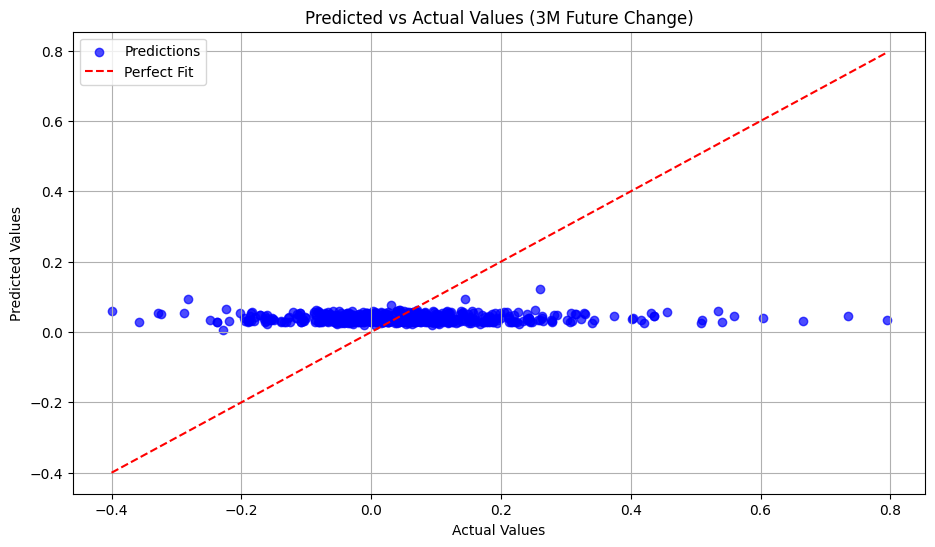

3M Future Change - R²: -0.0194
3M Future Change - MSE: 0.0223
3M Future Change - MAE: 0.1067

Overall Scores:
Mean - R²: -0.0194
Mean - MSE: 0.0223
Mean - MAE: 0.1067


In [12]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change']):
        y_test_actual = y_test[target].values
        if getattr(y_test_pred, "ndim", 1) == 1:
            y_test_pred_target = y_test_pred
        else:
            y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    # Overall metrics (single target)
    overall_pred = y_test_pred if getattr(y_test_pred, "ndim", 1) == 1 else y_test_pred[:, 0]
    mae = mean_absolute_error(y_test['3M Future Change'].values, overall_pred)
    mse = mean_squared_error(y_test['3M Future Change'].values, overall_pred)
    r2 = r2_score(y_test['3M Future Change'].values, overall_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [13]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        "iterations": iterations,
        'hidden_layer_sizes': [model.model.hidden_layer_sizes],
        'max_iter': model.model.max_iter,
        'n_iter_no_change': model.model.n_iter_no_change,
        'learning_rate': model.model.learning_rate,
        'learning_rate_init': model.model.learning_rate_init,
        'batch_size': model.model.batch_size,
        'tol': model.model.tol,
        'alpha': model.model.alpha,
        'shuffle': model.model.shuffle,
    })
    test_results.to_csv('../data/model_results/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../data/model_results/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

Old best R²: -0.4312013413018738
New best R²: -0.01935518946404602
Saving new best model...


## Predictions on latest data

In [14]:
best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: -0.019355189464046


In [ ]:
df_raw = pd.read_csv('../data/model_results/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_9m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_9m + y_pred_1y) / 4
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'Name': df_raw.loc[i*4, 'Name'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '9m (%)': y_pred_9m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

TypeError: cannot unpack non-iterable numpy.float64 object

In [ ]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"Not enough data for this stock at this moment \n Try another", "", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['9m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "", "")

In [ ]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker e.g. 'TSLA' or 'NVDA'"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="9 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d6f7567b4876962a6e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
